# Probabilistic generalized Polynomial Chaos Expansion

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden

The aim of this notebook is to show how to use `UQit` for non-intrusive probabilistic gPCE, hereafter called PPCE. In practice, we have the parameter samples and associated values of the model response. Therefore, we only want to construct the PPCE and estimate statistical moments of the model function due to the variability of the uncertain parameters. This basically means much of the coding in the following examples is not required. The theory about PPCE can be studied from [Owen](https://ore.exeter.ac.uk/repository/handle/10871/29296?show=full) and [Rezaeiravesh et. al](https://arxiv.org/pdf/2007.07071.pdf).

Consider parameter $\mathbf{q}\in \mathbb{Q}\subset\mathbb{R}^p$ which have a known distribution. Furthermore, the distribution of each parameter is assumed to be among what is defined in the standard generalized PCE. The explicit form of the simulator $f(q)$ is not known. However, the noisy observations are assumed to be generated as,

$$
y=f(q)+\varepsilon
$$

where $\varepsilon\sim\mathcal{N}(0,\sigma^2)$. If $\sigma$ is fixed (iid samples), we have homoscedastic noise and if $\sigma$ is observation-dependent then the noise is heteroscedastic. 
To estimate $\mathbb{E}[f(q)]$ and $\mathbb{V}[f(q)]$ using PPCE approach, we do the followings:
  * Given training data $\mathcal{D}=\{(q^{(i)},y^{(i)})\}_{i=1}^n$, a GPR is constructed.
  * For each sample drawn from the GPR, we construct a gPCE. Repeating this for $m$ samples, by the use of the Monte-Carlo approach stochastic estimates for $\mathbb{E}[f(q)]$ and $\mathbb{V}[f(q)]$ are made. 

In [1]:
import os
import sys
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from UQit.ppce import ppce
import UQit.pce as pce
import UQit.gpr_torch as gpr_torch
import UQit.stats as statsUQit
import UQit.analyticTestFuncs as analyticTestFuncs
import UQit.write as writeUQ
import UQit.reshaper as reshaper
import UQit.sampling as sampling

### Example 1: PPCE for one uncertain parameter

Consider the uncertain parameter $q\in\mathbb{Q}\subset\mathbb{R}$. 
For a set of samples from $f(q)$, we want to estimate $\mathbb{E}[f(q)]$ and $\mathbb{V}[f(q)]$ using PPCE approach. 

First, we need a few functions to synthetically generate training data:

In [2]:
def simulator(x,fType,qInfo):
    """Simulator"""
    yEx=analyticTestFuncs.fEx1D(x,fType,qInfo).val
    return yEx
#
def noiseGen(n,noiseType):
    """
    Generate a 1D numpy array of the standard deviation of the observation noise
    """
    if noiseType=='homo': #homoscedastic noise
       sd=0.1   #(non-zero, to avoid instabilities)
       sdV=[sd]*n
       sdV=np.asarray(sdV)
    elif noiseType=='hetero': #heteroscedastic noise
       sdMin=0.02
       sdMax=0.2
       sdV=sdMin+(sdMax-sdMin)*np.linspace(0.0,1.0,n)
    return sdV
#
def trainData(xInfo,n,noiseType,trainSamplyType,distType,fType):
    """Create training data D={X,Y}"""
    X_=sampling.trainSample(sampleType=trainSampleType,GQdistType=distType,qInfo=xInfo,nSamp=n)
    x=X_.q
    sdV=noiseGen(n,noiseType)
    y=simulator(x,fType,xInfo) + sdV * np.random.randn(n)
    return x,y,sdV

Different Settings for the whole process are set as below:

In [3]:
distType='Unif'      #type of distribution of the parameter (Acc. gPCE rule)
trainSampleType='unifRand'   #how to draw the trainining samples, see trainSample in sampling.py
qInfo=[-2,2.5]     #info about the parameter
                    #if 'Unif', qInfo =[min(q),max(q)]
                    #if 'Norm', qInfo=[m,v] for q~N(m,v^2)
n=35            #number of training samples in GPR
noiseType='hetero'   #'homo'=homoscedastic, 'hetero'=heterscedastic
nGQtest=15         #number of test points (=Gauss quadrature nodes)
#GPR options
nIter_gpr=1000      #number of iterations in optimization of hyperparameters
lr_gpr   =0.2       #learning rate for the optimization of the hyperparameters
convPlot_gpr=True   #plot convergence of the optimization of the GPR hyperparameters
nMC=2000            #number of samples drawn from GPR surrogate to construct estimates 
                    #  for the moments of f(q)

Generate the synthetic training data

In [4]:
if distType=='Unif':
   fType='type1'
elif distType=='Norm':
   fType='type2'
qTrain,yTrain,noiseSdev=trainData(qInfo,n,noiseType,trainSampleType,distType,fType)

Construct the PPCE

... Probabilistic PCE for 1D input parameter.
...... GPR-hyperparameters Optimization, iter 100/1000 - loss: 1.168 - lengthsc: 1.727
...... GPR-hyperparameters Optimization, iter 200/1000 - loss: 1.117 - lengthsc: 1.610
...... GPR-hyperparameters Optimization, iter 300/1000 - loss: 1.109 - lengthsc: 1.574
...... GPR-hyperparameters Optimization, iter 400/1000 - loss: 1.108 - lengthsc: 1.578
...... GPR-hyperparameters Optimization, iter 500/1000 - loss: 1.106 - lengthsc: 1.593
...... GPR-hyperparameters Optimization, iter 600/1000 - loss: 1.105 - lengthsc: 1.612
...... GPR-hyperparameters Optimization, iter 700/1000 - loss: 1.104 - lengthsc: 1.630
...... GPR-hyperparameters Optimization, iter 800/1000 - loss: 1.104 - lengthsc: 1.647
...... GPR-hyperparameters Optimization, iter 900/1000 - loss: 1.103 - lengthsc: 1.664
...... GPR-hyperparameters Optimization, iter 1000/1000 - loss: 1.102 - lengthsc: 1.680


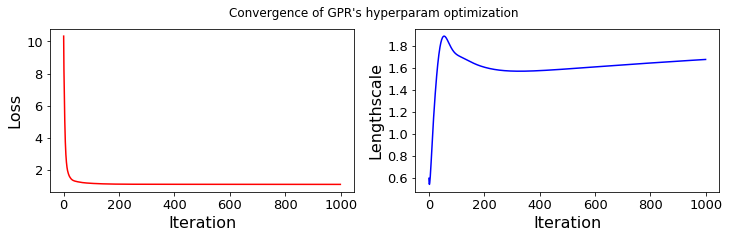

...... ppce repetition for finding samples of the PCE coefficients, iter = 200/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 400/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 600/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 800/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1000/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1200/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1400/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1600/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1800/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 2000/2000


In [5]:
ppceDict={'nGQtest':nGQtest,'qInfo':qInfo,'distType':distType,
          'nIter_gpr':nIter_gpr,'lr_gpr':lr_gpr,'convPlot_gpr':convPlot_gpr,'nMC':nMC}
ppce_=ppce(qTrain,yTrain,noiseSdev,ppceDict)
fMean_samples=ppce_.fMean_samps
fVar_samples=ppce_.fVar_samps
optOut=ppce_.optOut

Compare the estimated moments by PPCE with the exact values:

In [6]:
fEx_=analyticTestFuncs.fEx1D(qTrain,fType,qInfo)
fEx_.moments(qInfo)
fMean_ex=fEx_.mean
fVar_ex=fEx_.var
fMean_mean=fMean_samples.mean()
fMean_sdev=fMean_samples.std()
fVar_mean=fVar_samples.mean()
fVar_sdev=fVar_samples.std()
print(writeUQ.printRepeated('-', 80))
print('>> Exact mean(f) = %g' %fMean_ex)
print('   ppce estimated: E[mean(f)] = %g , sdev[mean(f)] = %g' %(fMean_mean,fMean_sdev))
print('>> Exact Var(f) = %g' %fVar_ex)
print('   ppce estimated: E[Var(f)] = %g , sdev[Var(f)] = %g' %(fVar_mean,fVar_sdev))

--------------------------------------------------------------------------------
>> Exact mean(f) = 10.948
   ppce estimated: E[mean(f)] = 10.9783 , sdev[mean(f)] = 0.192528
>> Exact Var(f) = 3.18976
   ppce estimated: E[Var(f)] = 3.00365 , sdev[Var(f)] = 0.604616


Plot histogram and PDF (probability density function) of the mean and variance distributions:

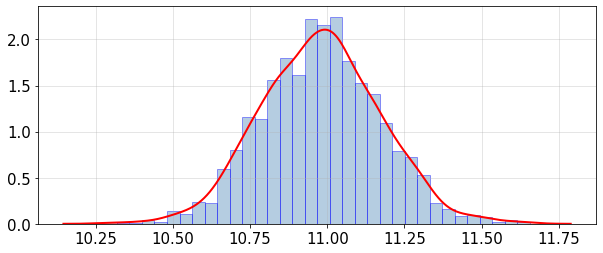

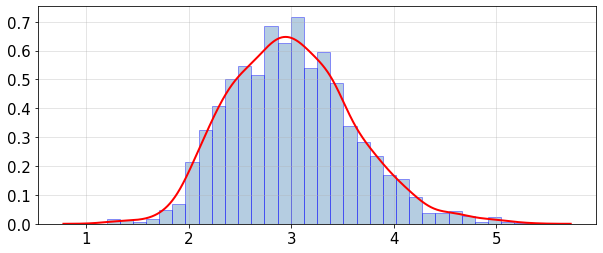

In [7]:
statsUQit.pdfFit_uniVar(fMean_samples,True,[])
statsUQit.pdfFit_uniVar(fVar_samples,True,[])

Plot the GPR surrogate along with the response from the exact simulator

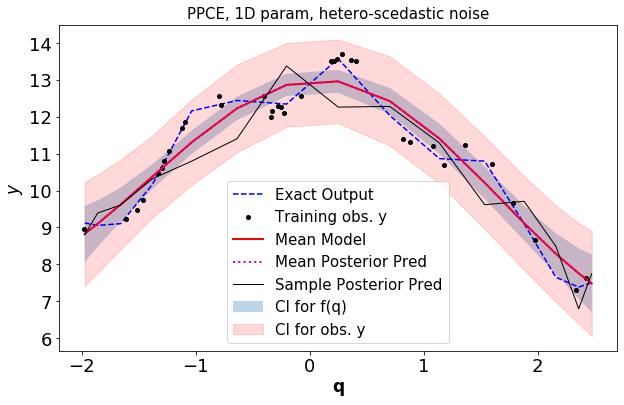

In [8]:
pltOpts={'title':'PPCE, 1D param, %s-scedastic noise'%noiseType}
gpr_torch.gprPlot(pltOpts).torch1d(optOut['post_f'],optOut['post_obs'],qTrain,yTrain,
        optOut['qTest'][0],simulator(optOut['qTest'][0],fType,qInfo))

### Example 2: PPCE for two parameters

Using `UQit`, we can apply PPCE to any number of uncertain parameters. Here, we consider two uncertain parameters $q_1\in\mathbb{Q}_1$ and $q_2\in\mathbb{Q}_2$, and use PPCE to estimate statistical moments of $f(\mathbf{q})$ for $\mathbf{q}\in \mathbb{Q}_1 \bigotimes \mathbb{Q}_1$.

First, the functions for generating the synthetic training samples.

In [9]:
def fEx(p,sampleType,n,qInfo,fExName):
    """Generate synthetic training data"""
    #  (a) xTrain
    nSamp=n[0]*n[1]
    xi=[]
    q=[]
    qBound=[]
    if sampleType[0]=='LHS' and sampleType[1]=='LHS':
       if distType==['Unif']*p:
          qBound=qInfo
          xi=sampling.LHS_sampling(nSamp,[[-1,1]]*p)
          xTrain=np.zeros((nSamp,p))
          for i in range(p):
              xTrain[:,i]=pce.mapFromUnit(xi[:,i],qBound[i])
          fEx_=analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp')
       else:
          raise ValueError("LHS works only when all q have 'Unif' distribution.")
    else:
       for i in range(p):
           samps=sampling.trainSample(sampleType=sampleType[i],GQdistType=distType[i],
                   qInfo=qInfo[i],nSamp=n[i])
           q.append(samps.q)
       xTrain=reshaper.vecs2grid(q)
       fEx_=analyticTestFuncs.fEx2D(q[0],q[1],fExName,'tensorProd')
    return xTrain,fEx_
#
def trainDataGen(p,sampleType,n,qInfo,fExName,noiseType):
    """Generate synthetic training data"""
    #  (a) xTrain and noise-free yTrain
    xTrain,fEx_=fEx(p,sampleType,n,qInfo,fExName)
    yTrain_noiseFree=fEx_.val
    nSamp=xTrain.shape[0]
    #  (b) set the sdev of the observation noise
    noiseSdev=noiseGen(nSamp,noiseType,xTrain,fExName)
    #  (c) Training data
    yTrain=yTrain_noiseFree+noiseSdev*np.random.randn(nSamp)
    return xTrain,yTrain,noiseSdev,yTrain_noiseFree,fEx_
#
def noiseGen(n,noiseType,xTrain,fExName):
    """Generate a 1D numpy array of standard deviation of the observation noise"""
    if noiseType=='homo':
       sd=0.2   #(non-zero, to avoid instabilities)
       sdV=sd*np.ones(n)
    elif noiseType=='hetero':
       sdV=0.1*(analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp').val+0.001)
    return sdV

Settings:

In [10]:
#settings for parameters and data
qInfo=[[-2,2],[-2,3]]    #info about the parameter
                         #if 'Unif', qInfo =[min(q),max(q)]
                         #if 'Norm', qInfo=[m,v] for q~N(m,v^2)
distType=['Unif','Unif']    #distribution type of parameters
fExName='type1'          #name of simulator to generate synthetic dat
                         #see analyticTestFuncs.fEx2D()
trainSampleType=['LHS','LHS']   #sampling type, see trainSample in sampling.py
n=[10,12]               #number of training samples for each parameter.
                        #note: n[0]*n[1]<128, due to GpyTorch
noiseType='hetero'      #type of observation noise
                        #'homo'=homoscedastic, 'hetero'=heterscedastic
#options for GPR
nIter_gpr=1000      #number of iterations in optimization of hyperparameters
lr_gpr   =0.1       #learning rate for the optimization of the hyperparameters
convPlot_gpr=True   #plot convergence of optimization of the GPR hyperparameters
#options for Gauss quadrature test nodes
nGQtest=[18,18]     #number of test samples in each param dimension
nMC=1000             #number of samples drawn from GPR surrogate to construct estimates 
                    # for the moments of f(q)

Generate synthetic training data

In [11]:
p=len(distType)   
qTrain,yTrain,noiseSdev,yTrain_noiseFree,fEx_=trainDataGen(p,trainSampleType,n,qInfo,fExName,noiseType)

Construct the PPCE

... Probabilistic PCE for 2-D input parameter.
...... GPR-hyperparameters Optimization, iter 100/1000 - loss: 0.747  lengthscales=1.014 0.971 
...... GPR-hyperparameters Optimization, iter 200/1000 - loss: 0.739  lengthscales=1.071 1.033 
...... GPR-hyperparameters Optimization, iter 300/1000 - loss: 0.737  lengthscales=1.101 1.065 
...... GPR-hyperparameters Optimization, iter 400/1000 - loss: 0.737  lengthscales=1.120 1.084 
...... GPR-hyperparameters Optimization, iter 500/1000 - loss: 0.736  lengthscales=1.132 1.096 
...... GPR-hyperparameters Optimization, iter 600/1000 - loss: 0.736  lengthscales=1.139 1.104 
...... GPR-hyperparameters Optimization, iter 700/1000 - loss: 0.736  lengthscales=1.144 1.109 
...... GPR-hyperparameters Optimization, iter 800/1000 - loss: 0.736  lengthscales=1.147 1.111 
...... GPR-hyperparameters Optimization, iter 900/1000 - loss: 0.736  lengthscales=1.148 1.113 
...... GPR-hyperparameters Optimization, iter 1000/1000 - loss: 0.736  lengthscales=1.149

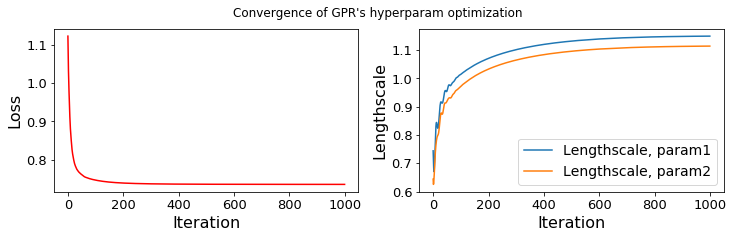

...... ppce repetition for finding samples of the PCE coefficients, iter = 100/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 200/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 300/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 400/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 500/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 600/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 700/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 800/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 900/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1000/1000


In [12]:
ppceDict={'nGQtest':nGQtest,'qInfo':qInfo,'distType':distType,'nIter_gpr':nIter_gpr,
          'lr_gpr':lr_gpr,'convPlot_gpr':convPlot_gpr,'nMC':nMC}
ppce_=ppce(qTrain,yTrain,noiseSdev,ppceDict)
optOut=ppce_.optOut
fMean_samples=ppce_.fMean_samps
fVar_samples=ppce_.fVar_samps

Estimate reference mean and varaiance of $f(q)$ using the Monte-Carlo approach

In [13]:
fEx_.moments(distType,qInfo)
fMean_mc=fEx_.mean
fVar_mc=fEx_.var

... Reference moments are calculated by the Monte-Carlo method with 100000 samples


Postprocess, plots, and comparison between the estimated moments of $f(q)$ with the reference values.

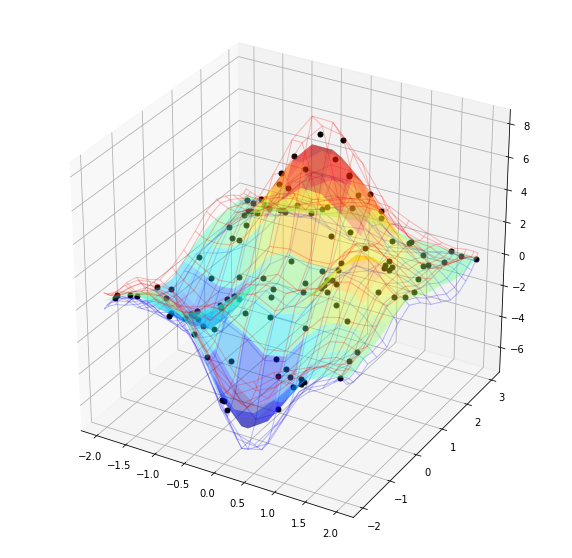

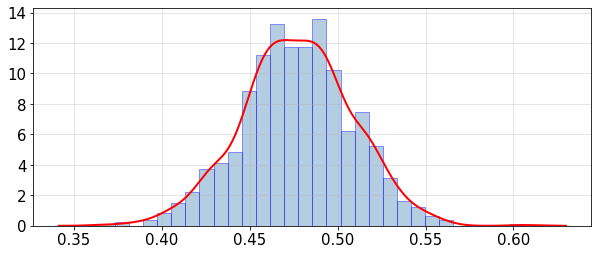

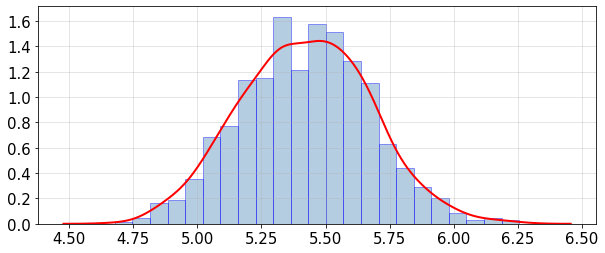

--------------------------------------------------------------------------------
Reference mean(f) = 0.534414
PPCE estimated: E[mean(f)] = 0.476933 , sdev[mean(f)] = 0.0314585
Reference var(f) = 5.92556
PPCE estimated: E[var(f)] = 5.42129 , sdev[var(f)] = 0.251345


In [14]:
#   (a) plot the exact and GPR response surfaces
gpr_torch.gprPlot().torch2d_3dSurf(qTrain,yTrain,optOut['qTest'],optOut['post_obs'])
#   (b) plot histogram and fitted pdf of the mean and variance distributions
statsUQit.pdfFit_uniVar(fMean_samples,True,[])
statsUQit.pdfFit_uniVar(fVar_samples,True,[])
#   (c) compare the reference moments with the estimated values by ppce
fMean_mean=fMean_samples.mean()
fMean_sdev=fMean_samples.std()
fVar_mean=fVar_samples.mean()
fVar_sdev=fVar_samples.std()
print(writeUQ.printRepeated('-', 80))
print('Reference mean(f) = %g' %fMean_mc)
print('PPCE estimated: E[mean(f)] = %g , sdev[mean(f)] = %g' %(fMean_mean,fMean_sdev))
print('Reference var(f) = %g' %fVar_mc)
print('PPCE estimated: E[var(f)] = %g , sdev[var(f)] = %g' %(fVar_mean,fVar_sdev))